# Internet Archive SavePageNow Data

The Internet Archive's [Save Page Now]() writes WARC data for archived web content to a particular Internet Archive collection called [liveweb](https://archive.org/details/liveweb). This archived web data is not available to the public, I think for privacy reasons, however basic metadata about the WARC data itself is. This notebook shows how you can examine this metadata to get a sense of the volume of data that is being added. It was developed as part of a research project with [Shawn Walker](http://shawnw.io/) and [Jess Ogden](https://archivingtheweb.me/).

## Install

If you are reading this you may have Jupyter already set up, but just in case you don't you'll want to install Python 3 and:

    % pip install pipenv
    % git clone https://github.com/edsu/spn
    % cd spn
    % pipenv install 
    
And now you'll need to save your Internet Archive account login details. If you don't have an account go over to archive.org and create one, and then:

    % ia configure
    
## Internet Archive Metadata

Now we're ready to load and use the [internetarchive](https://github.com/jjjake/internetarchive) Python extension:
    

In [1]:
import internetarchive as ia

Internet Archive organizes their stuff according to *collections*, which can contain one or many *items*. Each item then can contain one or many files. Collections and items have identifiers that uniquely identify them. For example if you know the the item identifier `liveweb-20180517162322` you can go get it and print its metadata:

In [2]:
item = ia.get_item('liveweb-20180517162322')
print(item.metadata)

{'identifier': 'liveweb-20180517162322', 'collection': ['liveweb', 'webwidecrawl', 'web'], 'mediatype': 'web', 'scanner': 'Internet Archive Python library 1.7.4', 'publicdate': '2018-05-17 16:24:11', 'title': 'liveweb-20180517162322', 'uploader': 'wbmcrawl@archive.org', 'addeddate': '2018-05-17 16:24:11', 'imagecount': '1104711', 'firstfiledate': '20180517054922', 'lastfiledate': '20180517175825', 'scandate': '20180517054922', 'date': '2018'}


It's a bit easier to read if we pretty print it:

In [3]:
from pprint import pprint
pprint(item.metadata)

{'addeddate': '2018-05-17 16:24:11',
 'collection': ['liveweb', 'webwidecrawl', 'web'],
 'date': '2018',
 'firstfiledate': '20180517054922',
 'identifier': 'liveweb-20180517162322',
 'imagecount': '1104711',
 'lastfiledate': '20180517175825',
 'mediatype': 'web',
 'publicdate': '2018-05-17 16:24:11',
 'scandate': '20180517054922',
 'scanner': 'Internet Archive Python library 1.7.4',
 'title': 'liveweb-20180517162322',
 'uploader': 'wbmcrawl@archive.org'}


Notice that the item identifier `liveweb-20180517162322` contains a date/time? We're going to take a bit of a leap here and assume that the date contained in there is the date that the WARC data was collected from SavePageNow. This might in fact not be the case, unless we learn more from Internet Archive about the provenance of this data.

There's actually much more detailed metadata available for the files in the item. Here's how many files are in the item:

In [4]:
print(len(item.item_metadata['files']))

62


We can see what metadata is available for the first file:

In [5]:
pprint(item.item_metadata['files'][0])

{'crc32': '9465c332',
 'format': 'Web ARChive GZ',
 'md5': 'd4282ca786cf235c0ab12e90ac48fe8b',
 'mtime': '1526577104',
 'name': 'cachegw-20180517054936-wwwb-app8.us.archive.org.warc.gz',
 'private': 'true',
 'sha1': 'd070f56bf40b647f3697484dd52c4dee44a46f50',
 'size': '524288349',
 'source': 'original'}


See the *size* property? After inspecting other public items I was able to verify that this is in fact the number of bytes for the file.

## Fetch the Data

So now we know enough to write a function that can return the date and the size of an item given its identifier.

In [6]:
import re

def item_summary(item_id):
    item = ia.get_item(item_id)

    size = 0
    for file in item.item_metadata['files']:
        if file['name'].endswith('arc.gz'):
            size += int(file['size'])
            
    m = re.match('^.+-(\d\d\d\d)(\d\d)(\d\d)', item.item_metadata['metadata']['identifier'])
    date = '%s-%s-%s' % m.groups()
    
    return date, size

Let's give a try:

In [7]:
print(item_summary('liveweb-20180517162322'))

('2018-05-17', 10752290761)


The internetarchive Python library doesn't offer an abstraction for collections. But it does provide a way to search for a collection and iterate through the items that it contains. So lets see how many items are contained in the collection:

In [8]:
num_items = len(ia.search_items('collection:liveweb'))
print(num_items)

30106


That's quite a few. If it takes a second to get the metadata for each item we are going to need to wait a while:

In [9]:
print(num_items / 60 / 60.0, 'hours')

8.362777777777778 hours


Ok, so let's go through each item, get the size and day for the item, and store them in a dictionary. Since there may be more than one item in a day it's important to add to the existing value for a date instead of simply storing it.

In [10]:
import os
import re
import json

sizes = {}

if not os.path.isfile('Sizes.csv'):

    for result in search_items('collection:liveweb'):
        date, size = item_summary(result['identifier'])
        sizes[date] = sizes.get(date, 0) + size
        print(date, size, sizes[date])

Now we can write out the *sizes* dictionary to a CSV file, where every row is a date. This way we won't need to fetch it every time we run this notebook.

In [11]:
if sizes:

    import csv

    dates = sorted(sizes.keys())

    with open('Sizes.csv', 'w') as output:
        writer = csv.writer(output)
        writer.writerow(['date', 'size'])
        for date in dates:
            writer.writerow([date, sizes[date]])

## Analyze the Data

So now we have our CSV of data we can analyze it a bit with [pandas](https://pandas.pydata.org/) and maybe generate a useful graph. First we'll import pandas and load in the data as a pandas DataFrame.

*Aside: I'm still learning pandas, and this is not meant to be a tutorial. If you want to learn more about all the amazing stuff you can do with it you'll want to spend some time in their excellent [tutorial](https://pandas.pydata.org/pandas-docs/stable/dsintro.html). If you work with R at all it should look pretty familiar. If not, treat this as just dipping your toe in to test the water. That's what I'm doing. If you do know pandas and notice a better way of doing any of this please let me know!*

In [12]:
import pandas as pd

sizes = pd.read_csv('Sizes.csv', index_col=0, parse_dates=True)
sizes.head()

,size
date,
2011-03-27,10646200928
2011-03-28,10707045468
2011-03-29,21394690378
2011-03-30,20976176471
2011-03-31,20678636646


It looks like the liveweb data started saving back in 2011. So now we've got a DataFrame that is indexed by the day, with one Series *size* that contains the bytes. I don't know about you, but I find it difficult to think of size in terms of bytes. So let's use pandas to calcuate a gigabyte column for us using the bytes:

In [13]:
sizes = sizes.assign(gb=lambda x: x / 1024 ** 3)
sizes.head()

,size,gb
date,,
2011-03-27,10646200928,9.915047
2011-03-28,10707045468,9.971713
2011-03-29,21394690378,19.925358
2011-03-30,20976176471,19.535587
2011-03-31,20678636646,19.258481


Now we can tell pandas to calcuate some statistics on our data:

In [14]:
sizes.describe()

,size,gb
count,2.577000e+03,2577.000000
mean,1.233640e+11,114.891670
std,1.576385e+11,146.812322
min,6.920293e+09,6.445025
25%,4.369936e+10,40.698201
50%,7.512312e+10,69.963859
75%,1.321588e+11,123.082494
max,1.848625e+12,1721.666143


## Visualize the Data

Since we have thousands of days, it might be useful to see the stats by month rather than by day. That's not too hard to do since our dataframe as a date index and pandas support for [timeseries](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries) data allows us to resample the dataframe on a monthly basis:

In [15]:
sizes_by_month = sizes.resample('M').sum()
sizes_by_month.head()

,size,gb
date,,
2011-03-31,84402749891,78.606186
2011-04-30,958748826767,892.904426
2011-05-31,1087027126597,1012.372902
2011-06-30,1318207232774,1227.676154
2011-07-31,1355729191892,1262.621201


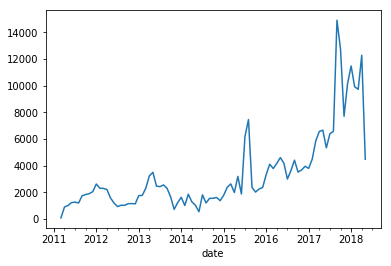

In [16]:
%matplotlib inline

sizes_by_month['gb'].plot()

Kinda cool right!? The dip at the end is the result of me running the data collection in the middle of May. So let's remove that:

Text(0.5,1,'Save-Page-Now Ingest Rate')

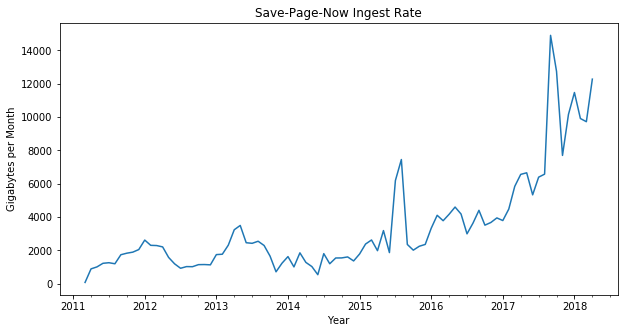

In [17]:
import datetime

sizes_without_may = sizes_by_month['gb'].drop(datetime.date(2018, 5, 31))

plot = sizes_without_may.plot(figsize=(10, 5))
plot.set_xlabel('Year')
plot.set_ylabel('Gigabytes per Month')
plot.set_title('Save-Page-Now Ingest Rate')

## Estimating Storage for Samples

As part of our research project we are looking to explore and characterize the data that is being archived by SPN. Part of this will involve looking at what URLs and domains are being collected, the HTTP headers that the client is sending (which preserving the anonymity of the client), and also perhaps some content analysis. Downloading 296 TB isn't probably going to be feasible, so we are planning to sample the data in two ways: interval and event based sampling. In order to prepare our own analysis environment we need to calculate how much storage we're going to need.

### Sampling by Interval

For the systematic sampling we are going to download a day of WARC data at routine intevals. Starting at the beginning of the SPN data up to the present day. We can use our data to figure out the start end end of the time period, and then use pandas to calcuate the dates we want to look at.

In [18]:
start_date = min(sizes.index)
end_date = max(sizes.index)
annual = pd.date_range(start_date, end_date, freq='A')
print(annual)

DatetimeIndex(['2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31',
               '2015-12-31', '2016-12-31', '2017-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')


Then we can use pandas to tell us the data sizes on those days as well as the total.

In [19]:
annual_sizes = sizes['gb'].filter(annual)
print(annual_sizes)
print()
print("Annual: %0.2f TB" % (sum(annual_sizes)/1024))

date
2011-12-31     48.475318
2012-12-31     20.080549
2013-12-31    312.535868
2014-12-31     41.109204
2015-12-31     51.898510
2016-12-31    144.981586
2017-12-31    362.544233
Name: gb, dtype: float64

Annual: 0.96 TB


We're not actually sure exactly how much storage space we'll have available to us so it could be useful to have some other ranges and their totals handy:

In [20]:
print("Biannual: %0.2f TB" % (sum(sizes['gb'].filter(pd.date_range(start_date, end_date, freq='6M'))) / 1024))
print("Monthly: %0.2f TB" % (sum(sizes['gb'].filter(pd.date_range(start_date, end_date, freq='1M'))) / 1024))
print("Biweekly: %0.2f TB" % (sum(sizes['gb'].filter(pd.date_range(start_date, end_date, freq='2W'))) / 1024))
print("Weekly: %0.2f TB" % (sum(sizes['gb'].filter(pd.date_range(start_date, end_date, freq='W'))) / 1024))

Biannual: 2.74 TB
Monthly: 10.11 TB
Biweekly: 21.04 TB
Weekly: 38.80 TB


### Sampling by Event

We also want to zoom in on particular event time periods to see if behavior around them changes significantly. Here is a short list we have for events:

* **Ferguson Protests** - 2014-08-09 - 2014-08-16
* **Brexit Vote** - 2016-06-16 - 2016-06-24
* **DataRescue** - 2018-01-15 - 2018-01-30

In [21]:
from datetime import date

ferguson = pd.date_range(date(2014, 8, 9), date(2014, 8, 16))
print('Ferguson %0.2f TB' % (sum(sizes['gb'].filter(ferguson)) / 1024))

brexit = pd.date_range(date(2016, 6, 16), date(2016, 6, 24))
print('Brexit %0.2f TB' % (sum(sizes['gb'].filter(brexit)) / 1024))

datarescue = pd.date_range(date(2018, 1, 15), date(2018, 1, 30))
print('DataRescue %0.2f TB' % (sum(sizes['gb'].filter(datarescue)) / 1024))


Ferguson 0.30 TB
Brexit 0.94 TB
DataRescue 6.10 TB


### Total Storage

This is accidentally kind of interesting because the DataRescue event does seem to be kind of anomlaous which you can see in the line graph above. So it looks like maximum we'd need at most **50 TB** of storage if we went with the weekly samply rate and the three events above. I suspect we'll want to have some processing space for derivative data, so maybe padding out to **75 TB** is a good idea? This will also let us decide on new events that we are interested in.

In [22]:
.3 + .94 + 6.1 + 38.8 

46.14